In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)

import tensorflow.keras.backend as K
from scipy.stats import norm

In [2]:
IMG_SIZE =64
N_CHANNELS = 3
BATCH_SIZE = 128
LATENT_DIM = 200
BETA = 2000
LEARNING_RATE = 0.0005
EPOCHS = 5
VALIDATION_SPLIT = 0.2
NUM_FEATURES = 64
LOAD_MODEL = True

In [3]:
#Celeb faces dataset
directory = r"C:\Users\Jayde\Desktop\Datasets\celeb_faces\img_align_celeba\img_align_celeba"
#also resizes the images to 64x64, interpolating between pixel values
train_data = utils.image_dataset_from_directory(directory,
                                               labels=None,
                                               color_mode="rgb",
                                               image_size=(IMG_SIZE,IMG_SIZE),
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42,
                                               interpolation="bilinear")

Found 202599 files belonging to 1 classes.


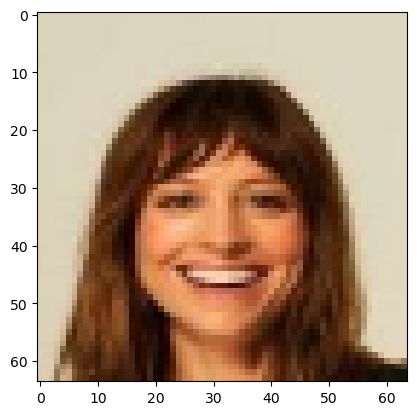

In [5]:
sample = train_data.take(1).get_single_element()
#this takes 1 batch, sample.shape = [128,64,64,3] = [n_batches,xdim,ydim,channels]
sample=sample[0] #one sample out of the batch
sample=sample.numpy() #tensorflow tensor to numpy array
plt.imshow(sample.astype("uint8") ,cmap= None)

In [6]:
#rescale from [0,255] to [0,1]
def preprocess(img):
    img= tf.cast(img,"float32") / 255 #tf.cast changes the tensor datatype 
    return img

In [7]:
#train = train_data.map(lambda x: preprocess(x))
train = train_data.map(preprocess)
train

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        #sameple epsilon from normal dist
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
encoder_input = layers.Input(shape= (IMG_SIZE,IMG_SIZE, N_CHANNELS))
x = layers.Conv2D(NUM_FEATURES, kernel_size = 3, strides = 2, padding = "same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) #default leakyrelu alpha value = 0.3

x = layers.Conv2D(NUM_FEATURES, kernel_size = 3, strides = 2, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size = 3, strides = 2, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size = 3, strides = 2, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size = 3, strides = 2, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:] #needed for the decoder

x= layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name= "z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]

In [10]:
# Decoder
decoder_input = layers.Input(shape=(LATENT_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(N_CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same")(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         36928     
 nspose)                                                     

In [11]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name = "kl_loss")

    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA*losses.binary_crossentropy(data, reconstruction, axis= (1,2,3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(1+ z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis =1,))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [12]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [13]:
# create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=LATENT_DIM),
    ],
)

In [36]:
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))
    decoder.load_weights("./models/decoder")
    encoder.load_weights("./models/encoder")

1/1 [==============================] - 2s 2s/step


In [20]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 220ms/step


Text(0.5, 0.48, 'Reconstructions')

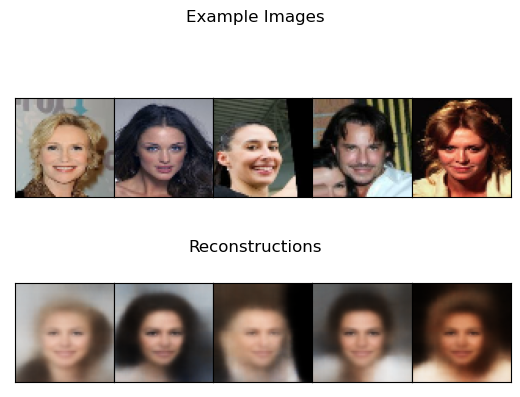

In [21]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
num_to_show = 5
fig, axs = plt.subplots(2,num_to_show)

plt.subplots_adjust(wspace=0, hspace=0)
for i in range(num_to_show):
    axs[0,i].imshow(example_images[i])
    axs[1,i].imshow(reconstructions[i])

    # Remove x and y ticks and labels for each subplot
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[0, i].set_xticklabels([])
    axs[0, i].set_yticklabels([])
    axs[1, i].set_xticklabels([])
    axs[1, i].set_yticklabels([])

fig.text(0.5, 0.96, "Example Images", ha='center', va='center', fontsize=12)
fig.text(0.5, 0.48, "Reconstructions", ha='center', va='center', fontsize=12)

4/4 [==============================] - 0s 42ms/step


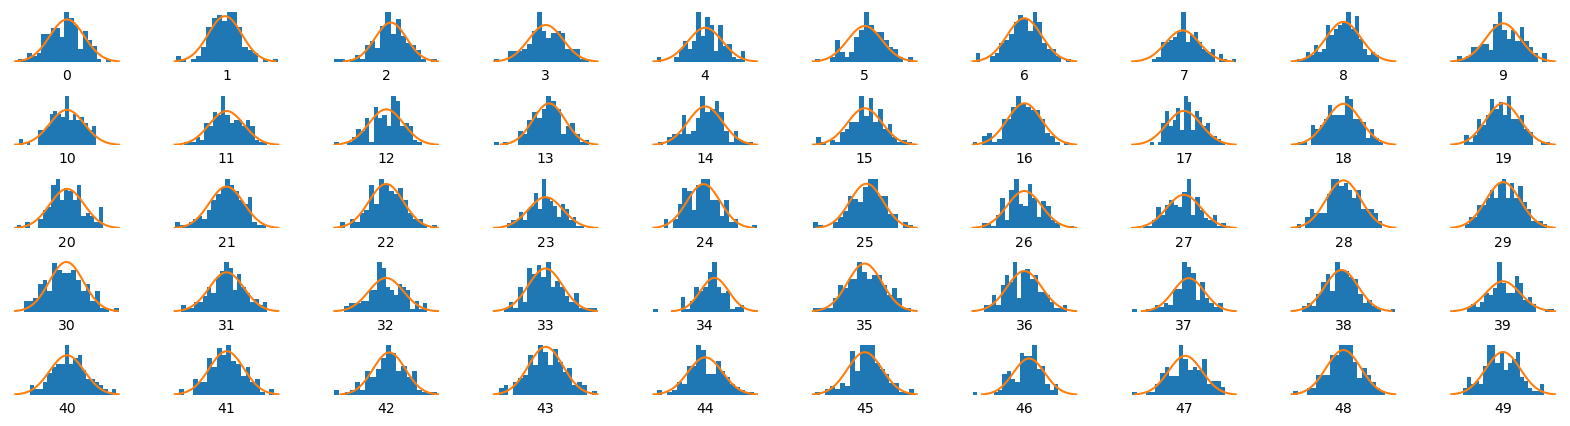

In [43]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

In [44]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, LATENT_DIM))

In [45]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 233ms/step


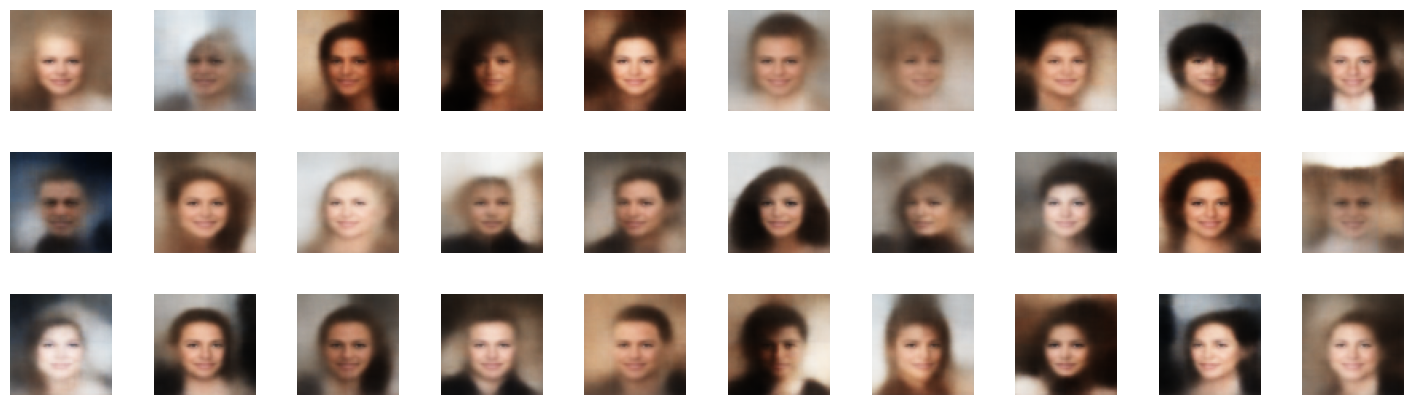

In [46]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])